In [190]:
import torch
from torchvision import transforms
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import numpy as np

In [191]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.eval()
print("Model loaded!")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Model loaded!


In [192]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [200]:
def preprocess(image, size):
    if isinstance(image, PIL.JpegImagePlugin.JpegImageFile) or isinstance(image, PIL.PngImagePlugin.PngImageFile):
        image = transforms.ToTensor()(image)

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size-12),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input = transform(image).unsqueeze(0)
    return input

def postprocess(tensor):
    transform1 = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255])
    tensor = transform1(tensor).cpu().detach().squeeze()#.permute(1,2,0)
    return tensor
    # transform2 = transforms.ToPILImage()
    # return transform2(tensor)
    
    #return transform(tensor).cpu().detach().squeeze().numpy().transpose((1,2,0))
    #return Image.fromarray(np.uint8(np_img)).convert('RGB'), np_img

def display_image(image):
    fig = plt.figure(figsize=(7.5,5), dpi=100)

    if isinstance(image, torch.Tensor) and image.shape[0] == 3:
        image = image.permute(1,2,0)

    plt.imshow(image)
    plt.show()

In [194]:
activation_layers = [15, 18, 20, 22, 25, 27, 29]

In [195]:
def deep_dream(model, image, activation_layer, num_iters, size, alpha=0.001):
    input = preprocess(image, size)
    activations_model = torch.nn.Sequential(*list(model.features.children())[:activation_layer])

    activations_model.to(device)
    input = input.to(device)

    input.requires_grad_(True)

    for itr in range(num_iters): 
        activations = activations_model(input)
        squared_sum = torch.sqrt((activations**2).sum())
        squared_sum.backward()
        input.data = input.data + alpha*input.grad.data
        input.grad.data.zero_()
        
    return postprocess(input)

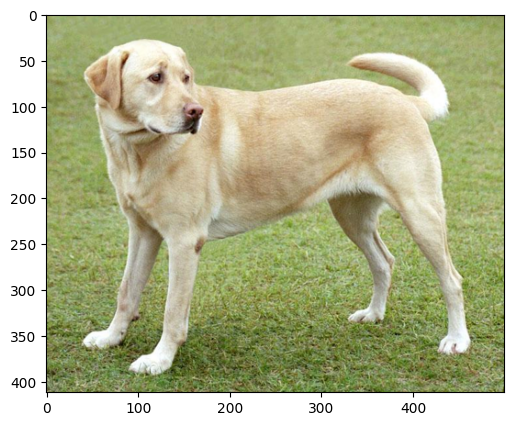

In [197]:
image = Image.open('good_dog.png')
display_image(image)

In [199]:
type(image)

PIL.PngImagePlugin.PngImageFile

In [201]:
dream_image = deep_dream(model, image, 30, 100, 225, alpha=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


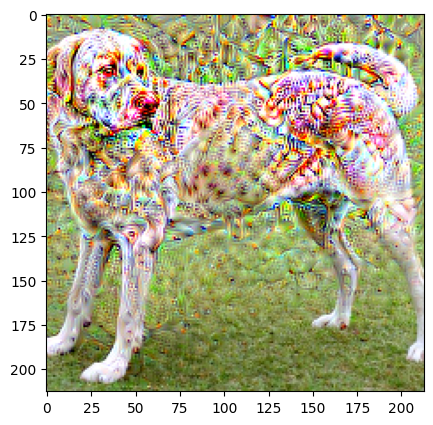

In [202]:
display_image(dream_image)
#display_image(np_img)

In [203]:
def deep_dream_octaves(model, image, activation_layer, num_iters, size, alpha=0.001, octave_limits=(-2,3), octave_scale=1.3):
    og_size = size
    
    for octave in reversed(range(*octave_limits)):
        curr_size = int(og_size*(octave_scale**octave))
        image = deep_dream(model, image, activation_layer, num_iters, curr_size, alpha)
        
    return postprocess(image)

In [204]:
dream_image = deep_dream_octaves(model, image, 30, 0, 400, alpha=0.3)

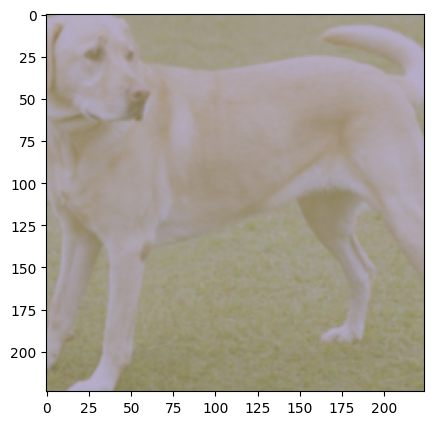

In [205]:
display_image(dream_image)

In [208]:
def deep_dream_octaves(model, image, layer, num_iters, alpha):
    out_img = image
    for i in range(5):
        out_img = deep_dream(model, out_img, layer, num_iters, int(400*(1.3**(3-i))), alpha)
    return out_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


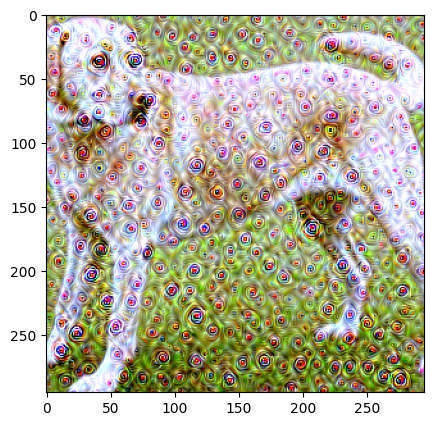

In [210]:
dream = deep_dream_octaves(model, image, 16, 50, 0.1)
display_image(dream)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


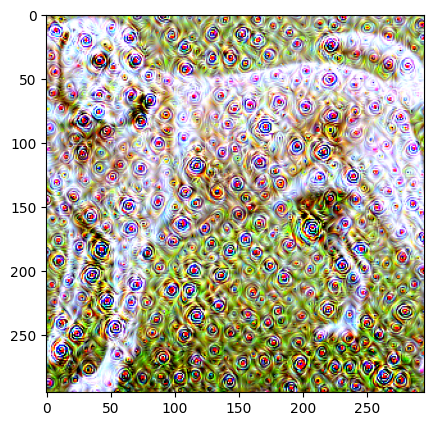

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


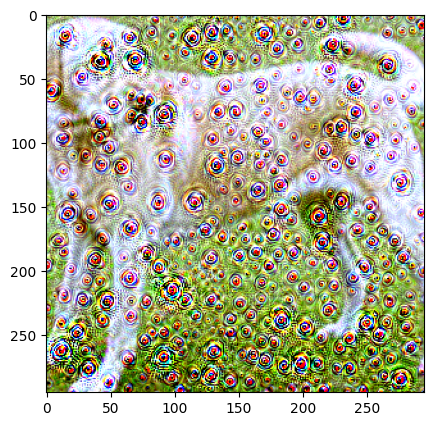

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


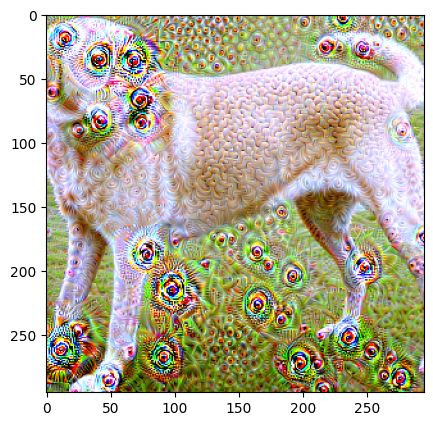

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


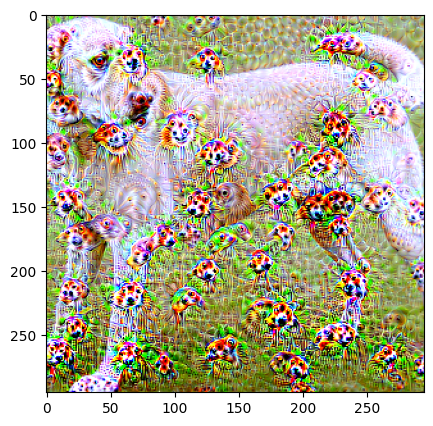

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


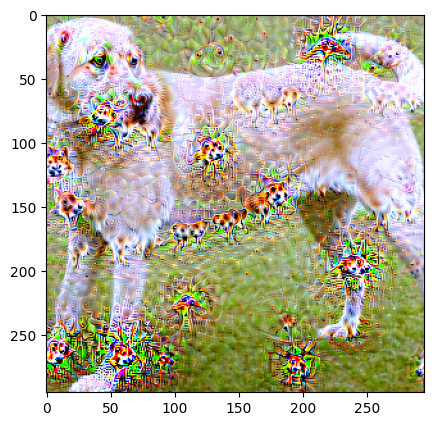

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


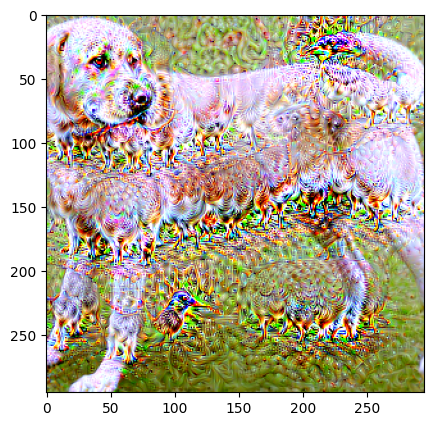

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


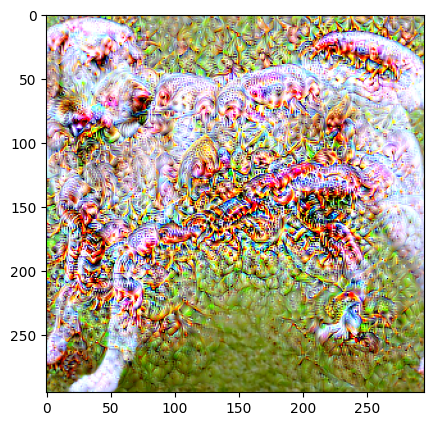

In [212]:
dream_images = []
for layer in activation_layers:
    dream_images.append(deep_dream_octaves(model, image, layer+1, 100, 0.1))

for image in dream_images:
    display_image(image)